## Simulating lensed and unlensed ZTF-like images

### Import python libraries

In [1]:
%pylab inline
import numpy as np
import copy
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
rc("font", family="serif")
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp1d
from scipy.stats import skewnorm
import scipy.stats as stats
from tqdm import tqdm
import sncosmo
import matplotlib.gridspec as gridspec



import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


### Import Lenstronomy libraries

In [2]:
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.SimulationAPI.sim_api as sim_api
import lenstronomy.SimulationAPI.observation_api as observation_api
from lenstronomy.Util import param_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Plots import lens_plot
import lenstronomy.Util.util as util
from lenstronomy.Util.numba_util import jit, nan_to_num

import os
os.environ['PATH']+=':/Library/TeX/texbin'
print(os.environ['PATH'])

/Users/remy/opt/anaconda3/bin:/Users/remy/opt/anaconda3/condabin:/Library/Frameworks/Python.framework/Versions/3.8/bin:/Library/Frameworks/Python.framework/Versions/3.9/bin:/anaconda3/bin:/Library/Frameworks/Python.framework/Versions/3.7/bin:/Library/Frameworks/Python.framework/Versions/3.4/bin:/Library/Frameworks/Python.framework/Versions/3.7/bin:usr/local/bin:/Library/Frameworks/Python.framework/Versions/2.7/bin/python2.7:/opt/local/bin:/opt/local/sbin:/Applications/CMake.app/Contents/bin:/usr/local/include:/Library/Frameworks/Python.framework/Versions/2.7/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin


### Running sep on simulated images

In [3]:
import sep
from scarlet import Starlet
from scarlet_extensions.initialization.detection import mad_wavelet

def makeCatalog(images, lvl=3, wave=True):
    ''' Creates a detection catalog by combining low and high resolution data
    This function is used for detection before running scarlet.
    It is particularly useful for stellar crowded fields and for detecting high frequency features.
    Parameters
    ----------
    datas: array
        array of Data objects
    lvl: int
        detection lvl
    wave: Bool
        set to True to use wavelet decomposition of images before combination
    Returns
    -------
    catalog: sextractor catalog
        catalog of detected sources
    bg_rms: array
        background level for each data set
    '''
    
    bkg = sep.Background(images[0])
    catalog = sep.extract(images[0], lvl, err=bkg.globalrms)

    return catalog, bkg



### ZTF PSF distribution

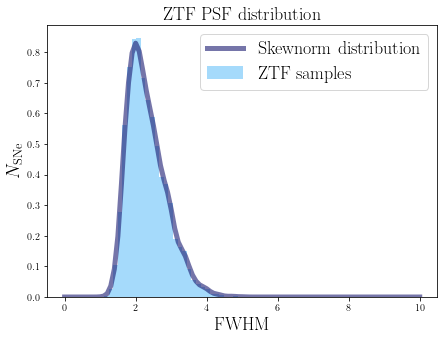

In [4]:
ZTF_psf_samples = skewnorm.rvs(5, loc=1.65, scale=0.875, size=5000)

figure(figsize = (7,5))

n2, x2, _ = hist(ZTF_psf_samples, bins=30, density=True, histtype='stepfilled', alpha=0.75, color="lightskyblue",
     label=r"$\mathrm{ZTF \ samples}$");

n1, x1 = np.histogram(ZTF_psf_samples, bins=100, range=(0, 10), density=True);
density1 = stats.gaussian_kde(ZTF_psf_samples)

xlabel(r"$\mathrm{FWHM}$", fontsize=18);
ylabel(r"$N_{\mathrm{SNe}}$", fontsize=18);
#plot(x1, density1(x1),'-', color="midnightblue", lw=5, alpha=0.6)
plot(x1, density1(x1),'-', color="midnightblue", lw=5, alpha=0.6, label=r'$\mathrm{Skewnorm \ distribution}$')
title(r"$\mathrm{ZTF \ PSF \ distribution}$", fontsize=18);
legend(fontsize=18);

#savefig("ZTF_PSF_distribution.pdf", bbox_inches="tight")

### Generating an ensemble of lensed and unlensed SNe images

#### Misc. notes & image characteristics:

* Only showing the lensed supernova images or unlensed supernova as point source in host galaxy
* Host (source) galaxy and lens galaxy are not shown as in typical YSE subtracted images, such that their light profiles are irrelevant
* Assumes Planck 2018 Cosmology
* Units are generally photon counts per pixel
* Pixel size of `delta_pix` = 0.25 arcsec implies a postage stamp extending 12.0 arcsecs for `numPix` = 48
* Background noise per pixel (Gaussian): `sigma_bkg` = 6.5
* Exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit): `exp_time` = 27 s
* Lens position is fixed at centre: `{'center_x': 0, 'center_y': 0}` (when specifying both Sersic profile and lens model)
* Point source amplitude `amp_ps`: We use the source redshift `z_source` to obtain the corresponding absolute magnitude (including K-correction) `abs_mag_ps`, which we then convert to apparent magnitude `app_mag_ps` while taking into account the computed magnification. Finally, we convert `app_mag_ps` to the data counts per second using the magnitude zero-point of the relevant band (e.g. i-band), which multiplied with the `exp_time` yields the desired `amp_ps`.

#### Parameters sampled from their respective distributions:

* Index to label lensed or unlensed SNe: `lensing_index` ~ Drawn from a discrete uniform distribution
* Full width half max of (Gaussian) PSF - `fwhm` ~ skewed Gaussian $(a=5, \mu=0.95, \sigma=0.375)$
* Redshift of lens: `z_lens` $\sim \mathcal{G}(0.4, 0.1)$
* Redshift of (lensed) source: `z_source` ~ skewed Gaussian $(a=2.5, \mu=0.67, \sigma=0.1)$
* Redshift of (unlensed) source: `z_source` ~ skewed Gaussian $(a=10, \mu=0.065, \sigma=0.1)$
* Source position: `(ra_source, dec_source)` ~ $\mathcal{G}(0, 0.65)$
* Source and lens galaxy intensity: both `amp` set to zero - their Sersic profiles are not irrelevant
* Microlensing - Need to specify intrinsic supernova brightness (`amp_ps`): `point_amp = mag_pert * amp_ps`, where `mag_pert` $\sim \mathcal{G}(\mathrm{mag}, 0.05)$, thereby perturbing observed (computed) magnification `mag`
* Lens model (power-law elliptical potential) parameters: `phi_lens` $\sim \mathcal{U}(-\pi/2, \pi/2)$, `q_lens` $\sim \mathcal{G}(0.7, 0.15)$, `theta_E` $\sim \mathcal{G}(1.1, 0.1)$, `gamma` $\sim \mathcal{G}(2.0, 0.1)$ (Note that this is a 6-parameter model, with `phi_lens` & `q_lens` used to compute `e1` & `e1`, with the `center_x` & `center_y` positions constituting the remaining 2 parameters)
* Environment parameters: shear angle, `phi_ext` $\sim \mathcal{U}(-\pi/2, \pi/2)$, shear strength, `gamma_ext` $\sim \mathcal{U}(0, 0.05)$

#### Light curve parameters:

* Stretch parameter `x_1` ~ skewed Gaussian $(a=-3.64, \mu=0.96, \sigma=1.15)$
* Colour parameter `c` ~ skewed Gaussian $(a=5.5, \mu=-0.11, \sigma=0.13)$
* Absolute magnitude without colour and stretch correlation `M_corrected` ~ $\mathcal{G}(-19.43, 0.12)$
* MW dust extinction `E(B-V)` ~ $\sim \mathcal{U}(0, 0.1)$
* Observation times: sampled between $\sim \mathcal{U}(-20, 0)$ and $\sim \mathcal{U}(10, 100)$ with a cadence of 6 days for YSE i-band.

In [5]:
# - - - Planck 2018 cosmology - - -
from astropy.cosmology import Planck18 as cosmo

# - - - Data specifics - - -
sigma_bkg = 8.5 # background noise per pixel (Gaussian)
exp_time = 30 # seconds # exposure time
numPix = 48 # cutout pixel size
deltaPix = 1. #  pixel size in arcsec (area per pixel = deltaPix**2)
patch_size = deltaPix*numPix
fwhm = 2.0

psf_type = 'GAUSSIAN' # 'GAUSSIAN', 'PIXEL', 'NONE'
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
data_class = ImageData(**kwargs_data)

# - - - Converting apparent magnitude to 'amp' for ZTF r-band - - -
obs_api = observation_api.SingleBand(pixel_scale=deltaPix, exposure_time=exp_time, magnitude_zero_point=24.20,
                                     read_noise=None, ccd_gain=None, sky_brightness=None, seeing=fwhm,
                                     num_exposures=1, psf_type='GAUSSIAN', kernel_point_source=None, truncation=5,
                                     data_count_unit='e-', background_noise=sigma_bkg)

sigma_bkg = obs_api.background_noise

print(sigma_bkg)

# - - - Light profiles - - -
# list of light profiles (for lens and source)
# 'SERSIC': spherical Sersic profile
lens_light_model_list = ['SERSIC']
# To turn lens on: set 'amp' to a nonzero value (for example 400)
kwargs_sersic = {'amp': 0, 'R_sersic': 1., 'n_sersic': 2, 'center_x': 0, 'center_y': 0}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

8.5


In [6]:
cadence = 3 # days
zlens_zSN_theta = np.load("sample_zl_zsn_theta.npz")['zlens_zSN_theta'] # samples from joint PDF
z_source_threshold = 0.9
theta_E_threshold = .0
z_source_list_ = []
z_lens_list_ = []
theta_E_list_ = []
for m in range(zlens_zSN_theta.shape[0]):
    if zlens_zSN_theta[m,1] < z_source_threshold and zlens_zSN_theta[m,1] > zlens_zSN_theta[m,0] and zlens_zSN_theta[m,2] > theta_E_threshold:
        z_source_list_.append(zlens_zSN_theta[m,1])
        z_lens_list_.append(zlens_zSN_theta[m,0])
        theta_E_list_.append(zlens_zSN_theta[m,2])

# - - - Make a grid - - - 
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix)
data = ImageData(**kwargs_data)
max_coordinate, min_coordinate = max(data.pixel_coordinates[0][0]), min(data.pixel_coordinates[0][0])
x_grid, y_grid = data.pixel_coordinates
x_grid1d = util.image2array(x_grid)
y_grid1d = util.image2array(y_grid)


# - - - Light curve specifics - - -
bandpass = 'ztfr'
dustmodel = sncosmo.F99Dust(r_v=3.1)
model = sncosmo.Model(source='salt2', effects=[dustmodel], effect_names=['mw'], effect_frames=['obs'])


# - - - Tripp Formula - - -
Alpha = 0.14
Beta = 3.1

def M_obs(x1_, c_, M_corrected_):
    return - Alpha * x1_ + Beta * c_ + M_corrected_

In [7]:
len(z_source_list_)

76842

### Generation of training, validation and test sets.

For training, we want a balanced data set, i.e. ~50% lensed/unlensed images, with a total of 80000 images, where 20% of the training data can be kept for validation. To that end, we draw a random number uniformly between 0 and 1, and if number is > 0.1, then lensed (`lensing index=1`), else, unlensed (`lensing index=0`). This takes into account the fact that ~12% of generated lensed images do not yield visible sources.
For testing, we generate a data set of 10000 images, with realistic ratio of unlensed to lensed images.

Note: `sum(lensing_index_list)/len(lensing_index_list)` will yield the fraction of lensed to unlensed images.

In [8]:
catalog_time_series = []
images_single = []
images_peak = []
max_time_delay = []
ra_source_list = []
dec_source_list = []
z_source_list = []
z_lens_list = []
theta_E_list = []
point_amp_list = []
abs_mag_ps_list = []
app_mag_ps_list = []
magnification_list = []
PSF_list = []
noise = []
data_labels = []
colour_param = []
stretch_param = []
time_stamps = []
NumSamples = int(len(z_source_list_)*2) # training (80%) + validation (20%)
limiting_magnitude = 21.3 #21.1 # For ZTF r-band
training = True
lensed_test = False
unlensed_test = False
index = 0 # Labels a given sample (both lensed and unlensed)
index_l = 0 # Labels lensed sample
counter = 0 # Total number of attempts
tqdm._instances.clear()
pbar = tqdm(total=NumSamples/4)
print(NumSamples/4.)

  0%|                                                                                                                                                    | 0/38421.0 [00:00<?, ?it/s]

38421.0


In [ ]:



# - - - Binary lensing label - - -
if training:
    lensing_index_list = np.random.randint(0, high=2, size=NumSamples)
    if sum(lensing_index_list) > len(z_source_list_):
        print("Not enough lensed samples!")
    # Drawing samples for combinations of (z_source, z_lens, theta_E)
    sample = np.random.choice(len(z_source_list_), size=len(z_source_list_), replace=False)
else:
    if unlensed_test:
        lensing_index_list = np.zeros([NumSamples], dtype=int)
    if lensed_test:
        lensing_index_list = np.ones([NumSamples], dtype=int)
        sample = np.random.choice(len(z_source_list_), size=len(z_source_list_), replace=False)

patience = []


# - - - Main generation loop - - -
while index < NumSamples/4.:
    patience.append(index)
    if len(patience) > 100:
        patience = []
        index += 1
        continue
    lensing_index = lensing_index_list[index]

    # - - - Lens configuration - - -
    if lensing_index == 0:
        z_source = float(skewnorm.rvs(5, loc=0.08, scale=0.1, size=1))
        z_lens = np.random.normal(0.4, 0.1) # Not used
        theta_E = 1.0 # Not used
        lens_model_list = []
    else:
        z_source = z_source_list_[sample[index_l]]
        z_lens = z_lens_list_[sample[index_l]]
        theta_E = theta_E_list_[sample[index_l]]
        lens_model_list = ['EPL', 'SHEAR_GAMMA_PSI'] # EPL = Elliptical power law mass profile

    # The following conditions are already enforced for lensed sources
    #if z_source > z_source_threshold or z_source < z_lens:
        #continue
    if z_source < 0 or z_lens < 0: # Safety check for unlensed sources
        continue

    # phi_ext: shear angle (in radian)
    # gamma_ext: shear strength
    kwargs_shear = {'gamma_ext': np.random.uniform(0, 0.05), 'psi_ext': np.random.uniform(-np.pi/2, np.pi/2)}

    phi_lens, q_lens = np.random.uniform(-np.pi/2, np.pi/2), np.random.normal(0.7, 0.15)
    while q_lens < 0 or q_lens > 1:
        q_lens = np.random.normal(0.7, 0.15)
    e1, e2 = param_util.phi_q2_ellipticity(phi_lens, q_lens)
    counter += 1

    kwargs_epl = {'theta_E': theta_E, 'gamma': np.random.normal(2.0, 0.1),
                    'center_x': 0, 'center_y': 0, 'e1': e1, 'e2': e2}
    kwargs_lens = [kwargs_epl, kwargs_shear]
    lens_model_class = LensModel(lens_model_list=lens_model_list, z_lens=z_lens, z_source=z_source, cosmo=cosmo)


    # - - - Source specification - - -
    source_model_list = ['SERSIC_ELLIPSE']
    if lensing_index == 1:
        ra_source, dec_source = np.random.normal(0, 0.3*theta_E), np.random.normal(0, 0.3*theta_E) #np.random.uniform(-theta_E, theta_E), np.random.uniform(-theta_E, theta_E)
    else:
        ra_source, dec_source = np.random.normal(0, 0.65), np.random.normal(0, 0.65)
    kwargs_sersic_ellipse = {'amp': 0, 'R_sersic': .1, 'n_sersic': 3, 'center_x': ra_source,
                             'center_y': dec_source, 'e1': -0.1, 'e2': 0.01}
    kwargs_source = [kwargs_sersic_ellipse]
    source_model_class = LightModel(light_model_list=source_model_list)

    lensEquationSolver = LensEquationSolver(lens_model_class)
    x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
                                                          min_distance=0.1, search_window=numPix * deltaPix)

    if lensing_index == 1 and x_image.sum() == 0:
        continue

    # compute lensing magnification at image positions
    mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
    mag = np.abs(mag) # ignore the sign of the magnification
    if lensing_index == 1 and mag.size < 2:
        continue

    # perturb observed magnification due to e.g. micro-lensing
    if lensing_index == 1:
        mag_pert = np.abs(np.random.normal(mag, 0.05, len(mag)))
    else:
        mag_pert = mag.copy() # This is unity


    # - - - Time delay surface - - -               # Geometric + gravitational time delay
    if lensing_index == 1:
        td_grid = lens_model_class.arrival_time(x_image=x_grid1d, y_image=y_grid1d, kwargs_lens=kwargs_lens)
        td_grid = util.array2image(td_grid)
        td_images = lens_model_class.arrival_time(x_image=x_image, y_image=y_image, kwargs_lens=kwargs_lens)
    else:
        td_images = 0.0


    # - - - Light curve - - - 
    MW_dust = np.random.uniform(0, 0.1)         # E(B-V)
    x1 = skewnorm.rvs(-3.638, 0.961, 1.151)     # Stretch parameter
    c = skewnorm.rvs(5.500, -0.108, 0.131)      # Colour parameter
    M_corrected = np.random.normal(-19.43, 0.12)# Absolute magnitude without colour/stretch correlation
    M_observed = M_obs(x1, c, M_corrected)      # Absolute magnitude with colour/stretch correlation

    model.set(z=z_source, t0=0.0, x1=x1, c=c, mwebv=MW_dust)
    model.set_source_peakabsmag(M_observed, 'bessellb', 'ab', cosmo=cosmo)
    x0 = model.get('x0')
    model.set(x0=x0)


    # - - - Observing days - - - 
    if lensing_index == 0:
        days = np.arange(model.mintime(), model.maxtime(), cadence)   
    else:
        days = np.arange(model.mintime() + min(td_images), model.maxtime() + max(td_images), cadence)

    # - - - Image time series - - - 
    time_series = []
    time_series_full = []
    point_amp_max = []
    app_mag_min = []
    app_mag_ps_list_ = []
    point_amp_list_ = []
    temp_index_list = []
    fwhm_list = []
    times = [] # Times where points are recorded relative to the begininning of the explosion
    time_series_cat = []
    temp_index = 0
    
    for day in days:
        # Sample PSF for each observed epoch
        fwhm = float(skewnorm.rvs(5, loc=1.65, scale=0.875, size=1))
        kwargs_psf = {'psf_type': psf_type, 'pixel_size': deltaPix, 'fwhm': fwhm}
        psf_class = PSF(**kwargs_psf)
        fwhm_list.append(fwhm)

        # Assign apparent magnitudes to point source and convert to amplitude parameter
        app_mag_ps = model.bandmag(bandpass, time=day - td_images, magsys='ab')
        amp_ps = obs_api.magnitude2cps(app_mag_ps)*exp_time

        # Filter out nans in the fluxes
        if lensing_index == 1:
            if np.any(np.isnan(amp_ps)):
                amp_ps[np.isnan(amp_ps)] = 0.0
        else:
            if np.isnan(amp_ps):
                amp_ps = 0.0

        point_amp = mag_pert*amp_ps  # multiply by intrinsic supernova brightness (in counts/s)
        #point_amp_list_.append(point_amp) # DKR
        point_amp_max.append(point_amp.max())
        app_mag_ps = np.nan_to_num(app_mag_ps, nan=np.inf)
        app_mag_ps -= 2.5*np.log10(mag_pert)
        app_mag_min.append(app_mag_ps.min())
        #app_mag_ps_list_.append(app_mag_ps) # DKR

        kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image, 'point_amp': point_amp}]

        if lensing_index == 0:
            point_source_list = ['SOURCE_POSITION']
            kwargs_ps = [{'ra_source': ra_source, 'dec_source': dec_source, 'point_amp': point_amp}]
        else:
            point_source_list = ['LENSED_POSITION']

        point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])
        kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}


        # - - - Create the image - - -
        imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)
        image_sim_ = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
        poisson = image_util.add_poisson(image_sim_, exp_time=exp_time)
        bkg = image_util.add_background(image_sim_, sigma_bkd=sigma_bkg)
        image_sim = image_sim_ + poisson + bkg
        
        time_series_full.append(image_sim)
        if app_mag_ps.min() < limiting_magnitude+5: #Added a +5 to let draw even if faint
            point_amp_list_.append(point_amp) # DKR
            app_mag_ps_list_.append(app_mag_ps) # DKR
            #time_series.append(image_sim)
            temp_index_list.append(temp_index)
            times.append(day)
            
            #Running detection with sep
            catalog, bg = makeCatalog(image_sim[None], lvl=3, wave=False)
            time_series_cat.append(catalog)
            
        temp_index += 1

        kwargs_data['image_data'] = image_sim
        data_class.update_data(image_sim)
    
        
            
    #print(min(app_mag_min)) # DKR
    if min(app_mag_min) > limiting_magnitude:
        continue

    if lensing_index == 0:
        data_labels.append([0,1])
    else:
        data_labels.append([1,0])
        index_l += 1
    
    index += 1
    pbar.update(1)
    
    np.random.shuffle(temp_index_list)
    # - - - Save all desired quantities - - -
    abs_mag_ps_list.append(M_observed)
    app_mag_ps_list.append(app_mag_ps_list_)
    catalog_time_series.append(time_series_cat)
    colour_param.append(c)
    dec_source_list.append(dec_source)
    images_peak.append(time_series_full[np.argmax(point_amp_max)]) # single-epoch model (peak)
    images_single.append(np.sum(time_series_full, axis = 0)) # single-epoch model (random among visible)
    magnification_list.append(mag_pert)
    point_amp_list.append(point_amp_list_)
    PSF_list.append(fwhm_list)
    ra_source_list.append(ra_source)
    stretch_param.append(x1)
    theta_E_list.append(theta_E)
    time_stamps.append(times)
    z_source_list.append(z_source)
    z_lens_list.append(z_lens)
    if lensing_index == 1:
        max_time_delay.append(abs(max(td_images) - min(td_images)))
    else:
        max_time_delay.append(0)
        
    if index%1000 == 0:
        np.savez("data/ZTF_training_images_26k_iband_image_properties_EPL_1.npz", 
                 data_labels=data_labels,z_source_list=z_source_list, point_amp_list=point_amp_list, 
                 abs_mag_ps_list=abs_mag_ps_list,app_mag_ps_list=app_mag_ps_list, 
                 theta_E_list=theta_E_list, PSF_list=PSF_list, colour_param=colour_param,
                 stretch_param=stretch_param, max_time_delay=max_time_delay, z_lens_list=z_lens_list, 
                 time_stamps=time_stamps,ra_source_list=ra_source_list, 
                 dec_source_list=dec_source_list, magnification_list=magnification_list)
        np.savez("data/ZFT_training_images_26k_iband_time_series_images_EPL_1.npz", 
                 catalog_time_series=catalog_time_series, images_single=images_single, images_peak=images_peak, 
                 time_stamps=time_stamps, data_labels=data_labels)


Not enough lensed samples!


 32%|██████████████████████████████████████████▏                                                                                       | 12480/38421.0 [64:49:22<77:05:04, 10.70s/it]

### Plot light curves

The two code snippets below are for plotting light curves for a lensed and unlensed supernova, respectively.

In [ ]:
### LENSED VERSION

# Plot light curve with observation epochs
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 5))
fig2.gca().invert_yaxis()
ax2.set_xlabel("Day", fontsize=18)
ax2.set_ylabel("Apparent magnitude", fontsize=18)
ax2.set_title(r"Light curve", fontsize=25)

colours = ['#3bb852','#1fa3a3','#205cd4','#7143bf']
fluxes = []
day_range = np.linspace(min([td_images])-100, max([td_images])+100, 1000)
#mags = model.bandmag(bandpass, time=days, magsys='ab')
for image in range(len([td_images])):
    flux = model.bandflux(bandpass, time=day_range - [td_images][image])
    flux *= mag_pert[image]
    fluxes.append(flux)
    mags_range = model.bandmag(bandpass, time=day_range - [td_images][image], magsys='ab')
    mags_range -= 2.5*np.log10(mag_pert[image])
    ax2.plot(day_range, mags_range, lw=2, label="Image " + str(image), color=colours[image])

zeropoint = sncosmo.ABMagSystem(name='ab').zpbandflux(bandpass)
total_flux = np.sum(fluxes, axis=0)
total_mag = -2.5 * np.log10(total_flux/zeropoint)
total_lightcurve = interp1d(day_range, total_mag, bounds_error=False)
ax2.plot(day_range, total_mag, '--', lw=2, color="gray", label="Total")
ax2.plot(days, total_lightcurve(days), '.', ms=10, color="black", label="Observations")
ax2.legend(loc=(1.01, 0.5), fontsize=18)
#fig2.savefig("Lightcurves_time_delays.png", transparent=False, facecolor='white', dpi=300, bbox_inches='tight')

### UNLENSED VERSION

# Plot light curve with observation epochs
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 5))
fig2.gca().invert_yaxis()
ax2.set_xlabel("Day", fontsize=18)
ax2.set_ylabel("Apparent magnitude", fontsize=18)
ax2.set_title(r"Light curve", fontsize=25)


colours = ['#3bb852','#1fa3a3','#205cd4','#7143bf']
fluxes = []
day_range = np.linspace(td_images-100, td_images+100, 1000)
#mags = model.bandmag(bandpass, time=days, magsys='ab')
image = 0
print(bandpass)
flux = model.bandflux(bandpass, time=day_range - td_images)
flux *= mag_pert[image]
fluxes.append(flux)
mags_range = model.bandmag(bandpass, time=day_range - td_images, magsys='ab')
mags_range -= 2.5*np.log10(mag_pert[image])
ax2.plot(day_range, mags_range, lw=2, label="Image " + str(image), color=colours[image])

zeropoint = sncosmo.ABMagSystem(name='ab').zpbandflux(bandpass)
total_flux = np.sum(fluxes, axis=0)
total_mag = -2.5 * np.log10(total_flux/zeropoint)
total_lightcurve = interp1d(day_range, total_mag, bounds_error=False)
ax2.plot(day_range, total_mag, '--', lw=2, color="gray", label="Total")
ax2.plot(days, total_lightcurve(days), '.', ms=10, color="black", label="Observations")
ax2.legend(loc=(1.01, 0.5), fontsize=18)
#fig2.savefig("Lightcurves_time_delays_unlensed.pdf", transparent=False, facecolor='white', dpi=300, bbox_inches='tight')

In [ ]:
print(np.shape(images_single))

imshow(images_single[17], cmap="viridis", origin="lower", extent=(-24,24,-24,24)) 
#colorbar()

In [ ]:
# acceptance
index/counter

In [ ]:
z_source_list

In [ ]:
np.array(theta_E_list)[np.where(np.array(data_labels)[0,:]==1)]

In [ ]:
sum(lensing_index_list)

In [ ]:
hist(theta_E_list, bins=25, histtype='step', density=True, lw=2, color="midnightblue", alpha=0.6);
#plot(theta_E, 9*pdf,'-', color="darkgoldenrod", lw=5, alpha=0.6, label=r'$\mathrm{Radek \ MC}$')
xlabel(r"$\theta_{\mathrm{E}}$", fontsize=15);
#xlabel(r"$m$", fontsize=15);
ylabel("Counts", fontsize=15);
title("Einstein radius distribution", fontsize=15);
#xlim(0,3.6);
#savefig("theta_E_distribution_EPL2.pdf", bbox_inches="tight")

In [ ]:
#hist(zlens_zSN_theta[:,0], bins=30, density=True, histtype='step', lw=2, color="crimson", label=r"$z_{\mathrm{lens}}$");
#hist(zlens_zSN_theta[:,1], bins=30, density=True, histtype='step', lw=2, color="C0", label=r"$z_{\mathrm{source}}$");

hist(z_source_list, bins=30, histtype='step', lw=2, color="C0", label=r"$z_{\mathrm{source}}$");
hist(z_lens_list, bins=30, histtype='step', lw=2, color="crimson", label=r"$z_{\mathrm{lens}}$");
xlabel("redshift", fontsize=15);
#xlabel(r"$m$", fontsize=15);
ylabel("Counts", fontsize=15);
title("Redshift distribution", fontsize=15);
legend(fontsize=15);
#savefig("redshift_distribution_EPL2.pdf", bbox_inches="tight")

In [ ]:
#hist(zlens_zSN_theta[:,0], bins=30, density=True, histtype='step', lw=2, color="crimson", label=r"$z_{\mathrm{lens}}$");
#hist(zlens_zSN_theta[:,1], bins=30, density=True, histtype='step', lw=2, color="C0", label=r"$z_{\mathrm{source}}$");

hist(ra_source_list, bins=30, histtype='step', lw=2, color="C0", label=r"RA$_{\mathrm{source}}$");
hist(dec_source_list, bins=30, histtype='step', lw=2, color="crimson", label=r"DEC$_{\mathrm{source}}$");
xlabel("position", fontsize=15);
#xlabel(r"$m$", fontsize=15);
ylabel("Counts", fontsize=15);
title("Source position distribution", fontsize=15);
legend(fontsize=15);
#savefig("redshift_distribution_EPL2.pdf", bbox_inches="tight")

In [ ]:
NumImages = []
for i in range(np.min([1000, len(point_amp_list)])):
    NumImages.append(len(point_amp_list[i][0]))
NumImages = np.array(NumImages)

hist(NumImages, bins=15, histtype='step', density=True, lw=2, color="midnightblue", alpha=0.6);
xlabel(r"$N_{\mathrm{images}}$", fontsize=15);
#xlabel(r"$m$", fontsize=15);
ylabel("Counts", fontsize=15);
title("Number of images", fontsize=15);
#xlim(0,3.6);
#savefig("Num_images_distribution_EPL2.pdf", bbox_inches="tight")

In [ ]:
hist(np.log10(max_time_delay), bins=27, range=(-1,4), histtype='step', lw=2, color="darkgoldenrod", label=r'simulated');
xlabel(r"$\log (\Delta t)$", fontsize=15);
#xlabel(r"$m$", fontsize=15);
ylabel("Counts", fontsize=15);
title("Time delay distribution", fontsize=15);
#legend(fontsize=15);
#xlim(0,700);
#savefig("max_time_delay_distribution_EPL2.pdf", bbox_inches="tight")

### Save images and all relevant quantities

In [ ]:
np.savez("data/ZTF_training_images_26k_iband_image_properties_EPL_1.npz", data_labels=data_labels,
         z_source_list=z_source_list, point_amp_list=point_amp_list, abs_mag_ps_list=abs_mag_ps_list,
         app_mag_ps_list=app_mag_ps_list, theta_E_list=theta_E_list, PSF_list=PSF_list, colour_param=colour_param,
         stretch_param=stretch_param, max_time_delay=max_time_delay, z_lens_list=z_lens_list, time_stamps=time_stamps,
         ra_source_list=ra_source_list, dec_source_list=dec_source_list, magnification_list=magnification_list)
np.savez("data/ZFT_training_images_26k_iband_time_series_images_EPL_1.npz", catalog_time_series=catalog_time_series,
         images_single=images_single, images_peak=images_peak, time_stamps=time_stamps, data_labels=data_labels)

#np.savez("data/lensed_test_images_10k_iband_image_properties_EPL2.npz", data_labels=data_labels,
         #z_source_list=z_source_list, point_amp_list=point_amp_list, abs_mag_ps_list=abs_mag_ps_list,
         #app_mag_ps_list=app_mag_ps_list, theta_E_list=theta_E_list, PSF_list=PSF_list, colour_param=colour_param,
         #stretch_param=stretch_param, max_time_delay=max_time_delay, z_lens_list=z_lens_list,
         #ra_source_list=ra_source_list, dec_source_list=dec_source_list, magnification_list=magnification_list)
#np.savez("data/lensed_test_images_10k_iband_time_series_images_EPL2.npz", images_time_series=images_time_series,
         #images_single=images_single, images_peak=images_peak, data_labels=data_labels)

#np.savez("data/unlensed_test_images_10k_iband_image_properties.npz", data_labels=data_labels,
         #z_source_list=z_source_list, point_amp_list=point_amp_list, abs_mag_ps_list=abs_mag_ps_list,
         #app_mag_ps_list=app_mag_ps_list, theta_E_list=theta_E_list, PSF_list=PSF_list, colour_param=colour_param,
         #stretch_param=stretch_param, max_time_delay=max_time_delay, z_lens_list=z_lens_list,
         #ra_source_list=ra_source_list, dec_source_list=dec_source_list, magnification_list=magnification_list)
#np.savez("data/unlensed_test_images_10k_iband_time_series_images.npz", images_time_series=images_time_series,
         #images_single=images_single, images_peak=images_peak, data_labels=data_labels)